<a href="https://colab.research.google.com/github/DGuzmanRomano/QuantumQuipu-challenge/blob/main/QuantumQuipu_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge: QuantumChallenge
### Team # 32
### Team Members
- Ayelen Perez | Argentina
- Jefferson Granizo | Ecuador
- Jesus Montemayor | Perú
- Rubén Guzmán | México
- Andres Diaz | Puerto Rico



# Exploración Cuántica en la Codificación y Clasificación de Datos

**Objetivos del Proyecto:**

* Diseño de Circuitos Cuánticos Variacionales: Implementación de estrategias de codificación cuántica.

* Enfoques Utilizados: Amplitude Encoding y Angle Encoding.

* Utilización de Datos: Columnas F1, F2, F3 y F4 para la clasificación.

* Evaluación y Comparación: Análisis exhaustivo del rendimiento de los modelos.



**Herramientas Utilizadas:**

* Qiskit: Biblioteca líder para la Computación Cuántica.
* Scikit-learn: Herramienta clave para el Machine Learning Clásico.
* Pandas: Manipulación eficiente de datos.
* Matplotlib y Seaborn: Visualización de resultados.


**Estrategias Implementadas:**

1. Amplitude Encoding
+ Feature Map: RawFeatureVector
+ Ansatz: RealAmplitudes
+ Validación Cruzada (k-Fold): Garantizando robustez en el rendimiento.

2. Angle Encoding
+ Feature Map: PauliFeatureMap
+ Ansatz: EfficientSU2
+ Validación Cruzada (k-Fold)

**Resultados y Conclusiones:**
+ Rendimiento Promedio: Validación cruzada y métricas en el conjunto de prueba.
+ Comparación de Enfoques: Evaluación detallada para identificar la estrategia más eficaz.


**Agradecimientos:**

Agradecemos la oportunidad de participar en este desafío!

In [ ]:
!pip install numpy matplotlib scikit-learn pandas
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit-aer
!pip install qiskit[qiskit_machine_learning]
!pip install pylatexenc
!pip install qiskit_algorithms

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from pandas._libs.missing import NA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit.utils import QuantumInstance, algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import KFold
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit


# Carga y analisis de datasets

Primero se analizó el dataset que consta de 4 features y 1 target de clasificación binaria, se comprobó que el dataset está balanceado con una distribución de clases de casi 50%-50% asi evitamos tener que realizar preprocesamiento para evitar bias, ademas se vió que se cuentan con 800 instancias, por lo que es un dataset pequeño, los valores de las caracteristicas son numeros de punto flotante con una gran cantidad de digitos.
Se comprobó ademas la consistencia de los datos, si existen instancias duplicadas y si hay valores vacios, resultando en que es un dataset consistente y balanceado, listo para trabajar.

In [9]:
algorithm_globals.random_seed = 32

train_df = pd.read_csv('challenge_train.csv').drop(columns=['Unnamed: 0'])
test_df = pd.read_csv('challenge_test.csv').drop(columns=['Unnamed: 0'])


X_train = train_df.drop('Target', axis=1).values
y_train = train_df['Target'].values
X_test = test_df.drop('Target', axis=1).values
y_test = test_df['Target'].values


# Combine train and test datasets for consistency checks
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check feature consistency
feature_consistency = combined_df.apply(lambda x: len(x.unique()))
print("\nFeature Consistency (Number of Unique Values per Feature):\n", feature_consistency)

# Check for data duplication
duplicated_entries = combined_df.duplicated()
print("\nDuplicated Entries:\n", combined_df[duplicated_entries])


class_counts = train_df['Target'].value_counts()
total_counts = len(train_df['Target'])
balance_info = class_counts / total_counts

print("\nClass distribution in the dataset:")
print(balance_info)
print("\n")

# Check if the target is balanced

threshold = 0.4  #
if balance_info.min() > threshold:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")


Missing Values:
 Series([], dtype: int64)

Feature Consistency (Number of Unique Values per Feature):
 F1        1000
F2        1000
F3        1000
F4        1000
Target       2
dtype: int64

Duplicated Entries:
 Empty DataFrame
Columns: [F1, F2, F3, F4, Target]
Index: []

Class distribution in the dataset:
1    0.50625
0    0.49375
Name: Target, dtype: float64


The dataset is balanced.


<ipython-input-9-eb1450cc9e1e>:1: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 32


# Pre-procesamiento
Al ser un dataset sin problemas evidentes, se probaron distintas configuraciones de escalado para las caracteristicas ya que presentan numeros con muchos digitos, por tanto muy separados entre si, al ser pocas caracteristicas y pocas instancias tampoco se realizó un procesamiento en ese sentido, tampoco se identificaron outliers.
La opción de escalado con mejores resultados fue MinMaxScaler para normalizar los datos.

In [10]:
#Parameters
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)


[[0.47127616 0.63945035 0.44096594 0.75885855]
 [0.57449798 0.58410799 0.28236492 0.56915001]
 [0.55790566 0.56919371 0.37882966 0.38061865]
 ...
 [0.63294732 0.0476897  0.29581521 0.69291343]
 [0.34864536 0.36479758 0.64688142 0.25805025]
 [0.66273462 0.59978692 0.49345913 0.38540937]]


# Codificación
En Quantum Machine Learning, la codificación o encoding es el proceso de transformar datos clasicos en estados cuanticos, se puede hacer de diversas maneras, en esté caso se hara la implementacion con Amplitude y Angle Encoding.

# Amplitude Encoding

Con la codificación de amplitud, un estado cuántico con n qubits se puede representar en un vector clásico de 2^n elementos. En este caso, con 2 qubits, podemos representar las 2^2 = 4 características del conjunto de datos.

# Feature Map
El Feature map es el encargado de realizar la codificacion de datos clasicos a estados cuanticos, la dimension es el numero de caracteristicas del dataset que van a ser mapeadas a estados cuanticos.
# RawFeatureVector
El feature map elegido para Amplitude encoding fue el Raw feature vector por ser especialmente diseñado para este tipo de codificación-

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


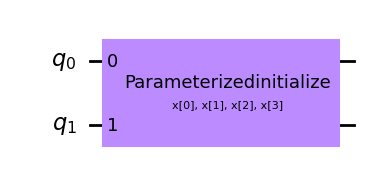

In [11]:
feature_map_amplitude = RawFeatureVector(feature_dimension=4)
feature_map_amplitude.draw(output='mpl')

# 2 qubits para dimensión 4

***********************
# Ansatz

El ansatz es el circuito cuantico parametrizado o variacional y se conecta a la salida del Feature map
El seleccionado fue RealAmplitudes con una gran variedad de parametros probados con un grid search y k-folds, finalmente los mejores fueron:

entrelazamiento = reverse linear
enlazando los qubits en orden regresivo (del ultimo al primero)

reps=6

Es el numero de veces que se repite el patrón del ansatz, mas repeticiones aumenta la expresividad del modelo pero aumenta la complejidad y un potencial Barren Plateau u overfitting.

qubit =2

El numero de qubits se mantiene en 2 al ser la salida del feature map la entrada del ansatz.

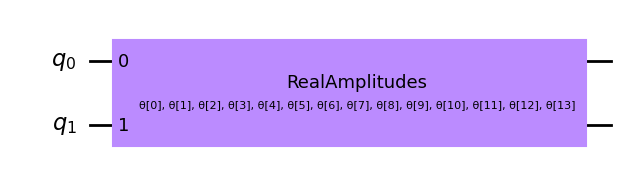

In [12]:
#ansatz parameters
entanglement = 'reverse_linear'
reps =  6
qbit = 2

ansatz_amplitude = RealAmplitudes(num_qubits=qbit, entanglement=entanglement, reps=reps)
ansatz_amplitude.draw(output='mpl')


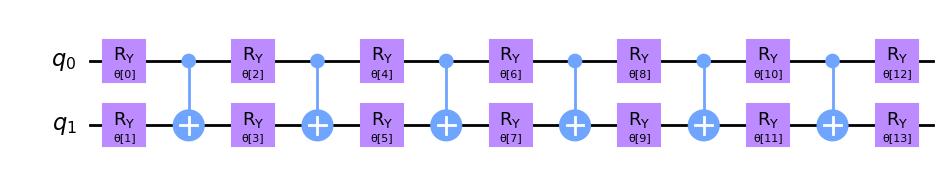

In [13]:
ansatz_amplitude.decompose().draw(output='mpl')


# 6 repeticiones de 2 qubits entrelazados con reverse linear

# Optimizador
En el proceso se usa un optimizador clasico ya que son eficientes y no se tiene una ventaja cuantica de hacerlo cuantico.
el seleccionado fue COBYLA por ser adecuado para problemas de optimización de pequeña escala.

Para las iteraciones se encontró que 150 daba los mejores resultados.

In [14]:
maxiter = 150
optimizer = COBYLA(maxiter=maxiter)

# VQC

Definicion del variational quantum classifier (VQC)
Es el clasificador seleccionado para procesar los datos, es un algoritmo hibrido que usa el circuito cuantico y el optimizador clasico.

Está diseñado para clasificar datos usando un ansatz.
Tras el grid search con mas de 200 combinaciones se obtuvo que los mejores parametros de feature map, ansatz, optimizer y para el sampler que es donde se va a simular el proceso cuantico None significa que el algoritmo selecciona por default el mejor simulador para el caso especifico.

In [15]:
# Define VQC algorithm
vqc_amplitude = VQC(num_qubits=2, feature_map=feature_map_amplitude, ansatz=ansatz_amplitude, optimizer=optimizer, sampler=None,)

# Validación cruzada

La validación cruzada se realiza para probar la configuración del modelo en varios pliegues de datos y asi ver su capacidad de generalizar y si su desempeño está condicionado a unos datos en especifico o no, confirmando la ausencia de overfitting, al tener pocos datos de entrenamiento esto tambien ayuda a probar el modelo con mas configuraciones y ver si en todas obtiene resultados similares.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np



# # # Initialize cross-validation for 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kfold.split(X_train_scaled, y_train):
    # Split the data
    X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Train the VQC model
    vqc_amplitude.fit(X_train_fold, y_train_fold)
    y_pred_fold = vqc_amplitude.predict(X_test_fold)
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)


    cv_scores.append(fold_accuracy)


cv_scores = np.array(cv_scores)

print(f"K-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std()}")



K-Fold Cross-Validation Scores: [0.975   0.95    0.94375 0.95    0.94375]
Mean CV Accuracy: 0.9524999999999999
Standard Deviation of CV Accuracy: 0.011592023119369634


Con 5 pliegues, se realizó un StratifiedKFold y los resultados muestran accuracy similar para los 5, con una desviación estandar baja, indicando que el modelo funciona bien en diferentes grupos de datos.

# Entrenamiento final del modelo

Finalmente, se entrena el modelo con el dataset completo y se obtienen las predicciones del conjunto de prueba.

In [ ]:
# fit the VQC model on the entire training set
vqc_amplitude.fit(X_train_scaled, y_train)
y_pred = vqc_amplitude.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)



# Metricas y resultados

Tras entrenar el modelo se obtienen diversas metricas para analizar el desempeño.

Con está configuración, se obtuvo un accuracy de
#0.99
Con un nivel igualmente alto en f1-score, recall y precision.

La matriz de confusión nos indica que solo hubo 2 falsos positivos.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

accuracy = test_accuracy
print(f"Accuracy: {accuracy}")
# Calculate metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Extracting true_positives, false_positives, false_negatives, true_negatives
tp, fn, fp, tn = cm.ravel()
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       106
           1       1.00      0.98      0.99        94

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Confusion Matrix:
[[106   0]
 [  2  92]]
True Positives: 106
False Positives: 2
False Negatives: 0
True Negatives: 92


# Angle Encoding

El segundo metodo seleccionado fue el Angle encoding que usa rotation gates para codificar la informacion en los estados cuanticos.

# PauliFeatureMap
El feature map tras pruebas se seleccionó el Pauli Feature Map, que utiliza compuertas de Pauli para codificar los estados cuanticos.

# Parametros

Feature dimension= 4 por nuestras 4 caracteristicas.

reps= 1
Pauli gates = X, Y

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


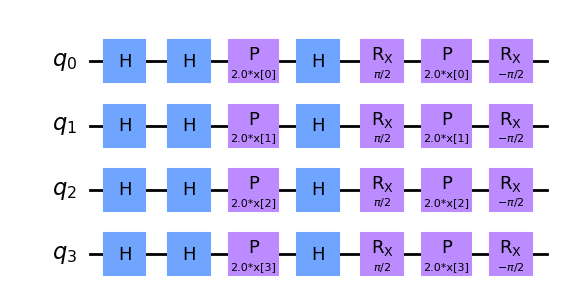

In [ ]:
from qiskit.circuit.library import PauliFeatureMap, EfficientSU2

# Feature map parameters
feature_reps = 1

barrier = False

feature_map_angle = PauliFeatureMap(feature_dimension=4, reps=feature_reps, paulis=['X','Y'], insert_barriers=barrier)
feature_map_angle.decompose().draw(output='mpl')


# Ansatz

El ansatz seleccionado fue
# EfficientSU2
Ya que está compuesto de compuertas su2 que realizan rotaciones de qubit que cubren la totalidad de la esfera de Bloch, obteniendo una alta expresividad.
# Parametros


entanglement = 'linear' //entrelazamiento linear

ansatz_reps = 3 //repeticiones

skip_final_rotation_layer = True //No rota los qubits al final del circuito

su2_gates = ['rx', 'ry'] //compuertas a usar

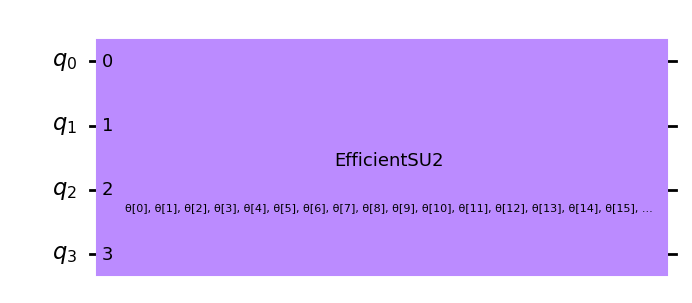

In [ ]:

# Ansatz parameters
entanglement = 'linear'

ansatz_reps = 3

skip_final_rotation_layer = True

su2_gates = ['rx', 'ry']


ansatz_angle = EfficientSU2(num_qubits=4, reps=ansatz_reps, entanglement=entanglement,
                    su2_gates=su2_gates, skip_final_rotation_layer=skip_final_rotation_layer)

ansatz_angle.draw(output='mpl')

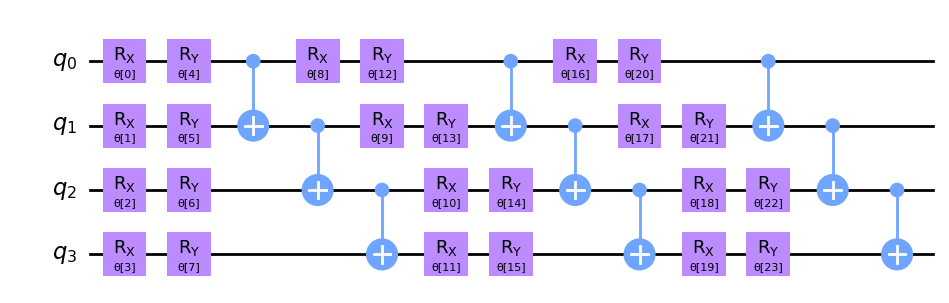

In [ ]:
ansatz_angle.decompose().draw(output='mpl')

# Optimizador

Se usa el mismo COBYLA con 150 iteraciones

# VQC

Se cargan los componentes al VQC con el sampler por default


In [ ]:
optimizer = COBYLA(maxiter=150)
vqc_angle = VQC(feature_map=feature_map_angle, ansatz=ansatz_angle, optimizer=optimizer, sampler=None)

# Validación cruzada

In [ ]:
# # # Initialize cross-validation for 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
cv_scores = []

for train_index, test_index in kfold.split(X_train_scaled, y_train):
    # Split the data
    X_train_fold, X_test_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Train the VQC model
    vqc_angle.fit(X_train_fold, y_train_fold)
    y_pred_fold = vqc_angle.predict(X_test_fold)
    fold_accuracy = accuracy_score(y_test_fold, y_pred_fold)


    cv_scores.append(fold_accuracy)


cv_scores = np.array(cv_scores)

print(f"K-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std()}")


K-Fold Cross-Validation Scores: [0.95625 0.96875 0.9625  0.94375 0.9625 ]
Mean CV Accuracy: 0.95875
Standard Deviation of CV Accuracy: 0.008477912478906594


# Resultados

Se obtuvo un accuracy de
# 0.97

con 6 falsos positivos

In [ ]:
vqc_angle.fit(X_train_scaled, y_train)
y_pred = vqc_angle.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
# Calculate metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Extracting true_positives, false_positives, false_negatives, true_negatives
tp, fn, fp, tn = cm.ravel()
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")

0.97
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       106
           1       1.00      0.94      0.97        94

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Confusion Matrix:
[[106   0]
 [  6  88]]
True Positives: 106
False Positives: 6
False Negatives: 0
True Negatives: 88


# Conclusión

Existen diversas maneras de codificar datos clasicos en estados cuanticos para Machine Learning, aun no hay un consenso de cual es mejor en segun que situación o uno que sea universalmente mejor que otro por lo que las pruebas deben realizarse, en este caso, analizando cientos de combinaciones determinamos que Amplitude encoding es ligeramente superior para el caso de estudio pero aun asi Angle encoding obtuvo resultados altos.